In [1]:
%matplotlib inline
import os
import json
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'
rcParams['font.size'] = 20

In [2]:
def read_rating(fname, rater=None):
    ds, sub = os.path.basename(os.path.splitext(fname)[0]).split('_')
    data = {'dataset': ds, 'subject': sub}
    if rater is not None:
        data['rater'] = rater
    
    with open(fname) as f:
        ratings = json.load(f)
    
    for reportlet in ratings['reports']:
        name = reportlet['name']
        
        if name == 'overall':
            data[name] = int(reportlet['rating'])
        elif '_T1w_' in name:
            data['t1_%s' % name.split('_T1w_')[-1]] = int(reportlet['rating'])
        elif '_bold_' in name:
            repname = 'bold_%s' % name.split('_bold_')[-1]
            data.setdefault(repname, []).append(int(reportlet['rating']))
        elif '_fieldmap_':
            repname = name.split('_fieldmap_')[-1]
            data.setdefault(repname, []).append(int(reportlet['rating']))
        else:
            print('Unsupported field name "%s"' % name)
        
    return data

In [3]:
def read_dataset(data_dir, fields=['overall', 't1_reconall', 't1_seg_brainmask', 't1_t1_2_mni',
                                   'bold_rois', 'bold_bbr', 'bold_syn_sdc']):
    dataset = [read_rating(f, rater='rater_1') for f in data_dir.glob('rater_1/*.json')]
    dataset += [read_rating(f, rater='rater_2') for f in data_dir.glob('rater_2/*.json')]

    infields = list(set([a for g in dataset for a in g.keys()]))
    infields.remove('dataset')
    infields.remove('subject')
    infields.remove('rater')
    headers = ['dataset'] + infields
    
    failed = []
    unrated = []
    
    # Average
    dfs = []
    for i, d in enumerate(dataset):
        if 'bold_variant-hmcsdc_preproc' in d:
            d['bold_rois'] = list(d['bold_rois']) + list(d['bold_variant-hmcsdc_preproc'])
            del d['bold_variant-hmcsdc_preproc']
        for k, v in d.items():
            if k in ['dataset', 'subject', 'rater']:
                continue

            if isinstance(v, list):
                filtered = [vv for vv in v if int(vv) > 0]
                if filtered:
                    d[k] = float(np.average(filtered))
                else:
                    d[k] = np.nan
            else:
                v = float(v) if int(v) > 0 else np.nan

        dfs.append(pd.DataFrame(d, columns=headers, index=[i]))
        
    # Merge raters
    allraters = pd.concat(dfs).sort_values(by='dataset')
    allraters[infields] = allraters[infields].clip(0.0)
    
    averaged = []
    for ds in set(allraters.dataset.ravel().tolist()):
        d = {'dataset': ds.upper()}
        group = allraters[allraters.dataset.str.contains(ds)]
        groupavg = np.mean(group[headers[1:]].values, axis=0)
        d.update({k: v for k, v in zip(headers[1:], groupavg)})
        averaged.append(pd.DataFrame(d, columns=headers, index=pd.Index([d['dataset']])))
    dataframe = pd.concat(averaged).sort_values(by='dataset')
    dataframe.index.name = 'dataset'
    
    dataframe['bold_bbr'] = dataframe[['bold_bbr', 'bold_coreg']].mean(axis=1)
#     dataframe['bold_rois'] = dataframe[
#         ['bold_rois'] + ['bold_variant-hmcsdc_preproc'] if 'bold_variant-hmcsdc_preproc' in headers else []].mean(axis=1)
    # 'fmap_mask', 'bold_fmap_reg', 'bold_fmap_reg_vsm', 
    return dataframe[fields].sort_values(by=fields, ascending=False)

In [4]:
dataframe = read_dataset(Path.home().joinpath('tmp/fmriprep-reports-2'))
dataframe0 = read_dataset(Path.home().joinpath('tmp/fmriprep-reports-1'))

In [5]:
dataframe0 = dataframe0.reindex(dataframe.index)

/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


{0.5: 2, 1.5: 4, 2.0: 9, 2.5: 26, 3.0: 12, nan: 1}
{1.25: 1, 1.75: 1, 2.0: 2, 2.3333333333333335: 1, 2.5: 4, 2.6666666666666665: 6, 2.75: 1, 3.0: 38}


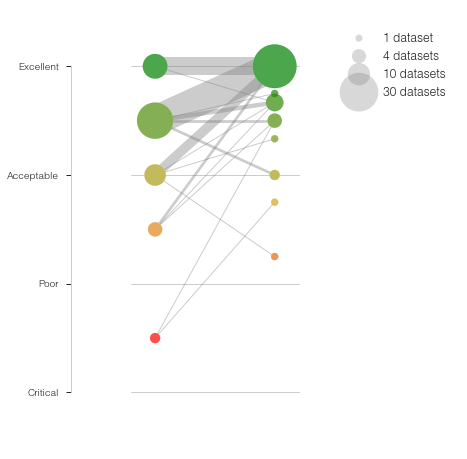

In [6]:
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap, Normalize
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid", {
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Helvetica Light'],
    'ytick.major.size': 5.0,
})
sns.set_context("notebook", font_scale=1)
dataframe['dataset'] = dataframe.index.ravel()
dataframe0['dataset'] = dataframe0.index.ravel()
dataframe['qc'] = [2] * len(dataframe)
dataframe0['qc'] = [1]  * len(dataframe0)


two = pd.concat((dataframe, dataframe0))
norm = Normalize(vmin=0.5, vmax=3.0)

# Show each observation with a scatterplot
# sns.stripplot(x='qc', y="overall", data=two, jitter=True)
cm = LinearSegmentedColormap.from_list('ratings', ['red', 'goldenrod', 'green'], N=50)

lines = [tuple(two[two['dataset'].str.contains(ds)].sort_values(by=['qc', 'overall'])[['overall']].values.ravel())
         for ds in set(two[['dataset']].values.ravel().tolist())]
lines = [l for l in lines if not np.any(np.isnan(l))]
#         plt.plot((1, 2), y, color='gray', linewidth=1.0, alpha=0.6)

factor = 50

fig = plt.figure(figsize=(3, 8))
ax = plt.gca()
for u, c in Counter(lines).items():
     ax.plot((1, 2), u, color='gray', linewidth=(c-1) * 1.7 + 1, zorder=1, alpha=0.4)

# Plot qc1
unique, counts = np.unique(dataframe0[['overall']].values.ravel(), return_counts=True)
qc1_counts = dict(zip(unique, counts))
ax.scatter([1] * len(unique), unique, c='w', s=counts * factor, zorder=2)
qc1_scatter = ax.scatter([1] * len(unique), unique, c=cm(norm(unique)), alpha=0.7, s=counts * factor, zorder=3)

print(dict(zip(unique, counts)))

# Plot qc2
unique, counts = np.unique(dataframe[['overall']].values.ravel(), return_counts=True)
qc2_counts = dict(zip(unique, counts))
ax.scatter([2] * len(unique), unique, c='w', s=counts * factor, zorder=2)
qc2_scatter = ax.scatter([2] * len(unique), unique, c=cm(norm(unique)), alpha=0.7, s=counts * factor, zorder=3)

print(dict(zip(unique, counts)))

ax.set(xticks=[])
ax.set(xticklabels=[])
ax.set(yticks=[0.0, 1.0, 2.0, 3.0])
ax.set(yticklabels=['Critical', 'Poor', 'Acceptable', 'Excellent'])
ax.set_xlim((0.8, 2.2))
ax.set_ylim((-0.5, 3.5))


sc = [
    plt.scatter([],[], s=factor * 1, color='gray', edgecolors='none', alpha=.3),
    plt.scatter([],[], s=factor * 4, color='gray', edgecolors='none', alpha=.3),
    plt.scatter([],[], s=factor * 10, color='gray', edgecolors='none', alpha=.3),
    plt.scatter([],[], s=factor * 30, color='gray', edgecolors='none', alpha=.3)
]

labels = ["1 dataset", "4 datasets", "10 datasets", "30 datasets"]

leg = plt.legend(sc, labels, ncol=1, frameon=False, fontsize=12,
                 handlelength=2, loc=1, borderpad = 1.2,
                 handletextpad=1, scatterpoints = 1,
                 bbox_to_anchor=(2.0, 1.0))

sns.despine(offset=60, trim=True);
sns.despine(bottom=True)

plt.savefig('figure04.svg', format='svg', bbox_inches='tight', pad_inches=0, dpi=300)

In [8]:
from scipy import stats
from seaborn.categorical import _CategoricalScatterPlotter
from seaborn.axisgrid import PairGrid
from matplotlib.colors import LinearSegmentedColormap, Normalize

class MyPairGrid(PairGrid):
    def __init__(self, data, data0, hue=None, hue_order=None, palette=None,
                 hue_kws=None, vars=None, x_vars=None, y_vars=None,
                 diag_sharey=True, size=2.5, aspect=1,
                 despine=True, dropna=True):
        super(MyPairGrid, self).__init__(
            data, hue=hue, hue_order=hue_order, palette=palette, hue_kws=hue_kws,
            vars=vars, x_vars=x_vars, y_vars=y_vars, diag_sharey=diag_sharey,
            size=size, aspect=aspect, despine=despine, dropna=dropna
        )
        self.data0 = data0.reindex(data.index)
        self.hue_names = None
        
    def map(self, func, **kwargs):
        """Plot with the same function in every subplot.
        Parameters
        ----------
        func : callable plotting function
            Must take x, y arrays as positional arguments and draw onto the
            "currently active" matplotlib Axes.
        """
        kw_color = kwargs.pop("color", None)

        for j, x_var in enumerate(self.x_vars):
            ax = self.axes[0, j]
            plt.sca(ax)
            func(self.data[[x_var]], self.data0[[x_var]], self.data[['dataset']],
                 **kwargs)

            self._clean_axis(ax)
            self._update_legend_data(ax)


# class _StripPlotter(_CategoricalScatterPlotter):
#     """1-d scatterplot with categorical organization."""
#     def __init__(self, x, y, hue, data, order, hue_order,
#                  jitter, dodge, orient, color, palette):
#         """Initialize the plotter."""
#         print(x, y)
#         print(hue)
#         print(data)
#         self.establish_variables(x, y, hue, data, orient, order, hue_order)
#         self.establish_colors(color, palette, 1)

#         # Set object attributes
#         self.dodge = dodge
#         self.width = .8

#         if jitter == 1:  # Use a good default for `jitter = True`
#             jlim = 0.1
#         else:
#             jlim = float(jitter)
#         if self.hue_names is not None and dodge:
#             jlim /= len(self.hue_names)
#         self.jitterer = stats.uniform(-jlim, jlim * 2).rvs

#     def draw_stripplot(self, ax, kws):
#         """Draw the points onto `ax`."""
#         # Set the default zorder to 2.1, so that the points
#         # will be drawn on top of line elements (like in a boxplot)
#         for i, group_data in enumerate(self.plot_data):
#             if self.plot_hues is None or not self.dodge:

#                 if self.hue_names is None:
#                     hue_mask = np.ones(group_data.size, np.bool)
#                 else:
#                     hue_mask = np.array([h in self.hue_names
#                                          for h in self.plot_hues[i]], np.bool)
#                 strip_data = group_data[hue_mask]

#                 # Plot the points in centered positions
#                 cat_pos = np.ones(strip_data.size) * i
#                 cat_pos += self.jitterer(len(strip_data))
#                 kws.update(c=self.point_colors[i][hue_mask])
#                 if self.orient == "v":
#                     , **kws)
#                 else:
#                     ax.scatter(strip_data, cat_pos, **kws)

#             else:
#                 offsets = self.hue_offsets
#                 for j, hue_level in enumerate(self.hue_names):
#                     hue_mask = self.plot_hues[i] == hue_level
#                     strip_data = group_data[hue_mask]

#                     # Plot the points in centered positions
#                     center = i + offsets[j]
#                     cat_pos = np.ones(strip_data.size) * center
#                     cat_pos += self.jitterer(len(strip_data))
#                     kws.update(c=self.point_colors[i][hue_mask])
#                     if self.orient == "v":
#                         ax.scatter(cat_pos, strip_data, **kws)
#                     else:
#                         ax.scatter(strip_data, cat_pos, **kws)

#     def plot(self, ax, kws):
#         """Make the plot."""
#         self.draw_stripplot(ax, kws)
#         self.add_legend_data(ax)
#         self.annotate_axes(ax)
#         if self.orient == "h":
#             ax.invert_yaxis()
            
            
def stripplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None,
              jitter=False, dodge=False, orient=None, color=None, palette=None,
              size=5, edgecolor="gray", linewidth=0, ax=None, **kwargs):
    plotter = _StripPlotter(x, y, hue, data, order, hue_order,
                            jitter, dodge, orient, color, palette)
    if ax is None:
        ax = plt.gca()

    kwargs.setdefault("zorder", 3)
    size = kwargs.get("s", size)
    if linewidth is None:
        linewidth = size / 10
    if edgecolor == "gray":
        edgecolor = plotter.gray
    kwargs.update(dict(s=size ** 2,
                       edgecolor=edgecolor,
                       linewidth=linewidth))

    plotter.plot(ax, kwargs)
    return ax


def mystripplot(x=None, x0=None, y=None, hue=None, data=None, order=None, hue_order=None,
                jitter=False, dodge=False, orient=None, color=None, palette=None,
                size=5, edgecolor="gray", linewidth=0, ax=None, **kwargs):

    if ax is None:
        ax = plt.gca()

    # colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # R -> G -> B
    colors = ['red', 'goldenrod', 'green']
    cm = LinearSegmentedColormap.from_list('ratings', colors, N=50)
    norm = Normalize(vmin=0.5, vmax=3.0)
      
    y = range(len(y))[::-1]
    ecs = [cm(norm(v)) for v in x0.values.ravel()]
    ax.scatter(x0, y, c='w', linewidth=2, edgecolors=ecs, s=120, zorder=2)

    incs = np.squeeze((x - x0).values.ravel())
    for i, inc in enumerate(incs):
        if not np.isnan(inc) and abs(inc) > 0.5:
            inc += -0.5 if inc > 0.0 else 0.5
            c = 'orange' if inc < 0 else 'dodgerblue'
            ax.arrow(x0.values.ravel()[i], y[i], inc, 0, linewidth=5, head_width=0.05, head_length=0.08, fc=c, ec=c, zorder=1, alpha=0.5)

    ecs = [cm(norm(v)) for v in x.values.ravel()]
    ax.scatter(x, y, linewidth=2, s=120, c=ecs, zorder=3)
    return ax

/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_pdf.py:1121: UserWarning: 'Helvetica-Light.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


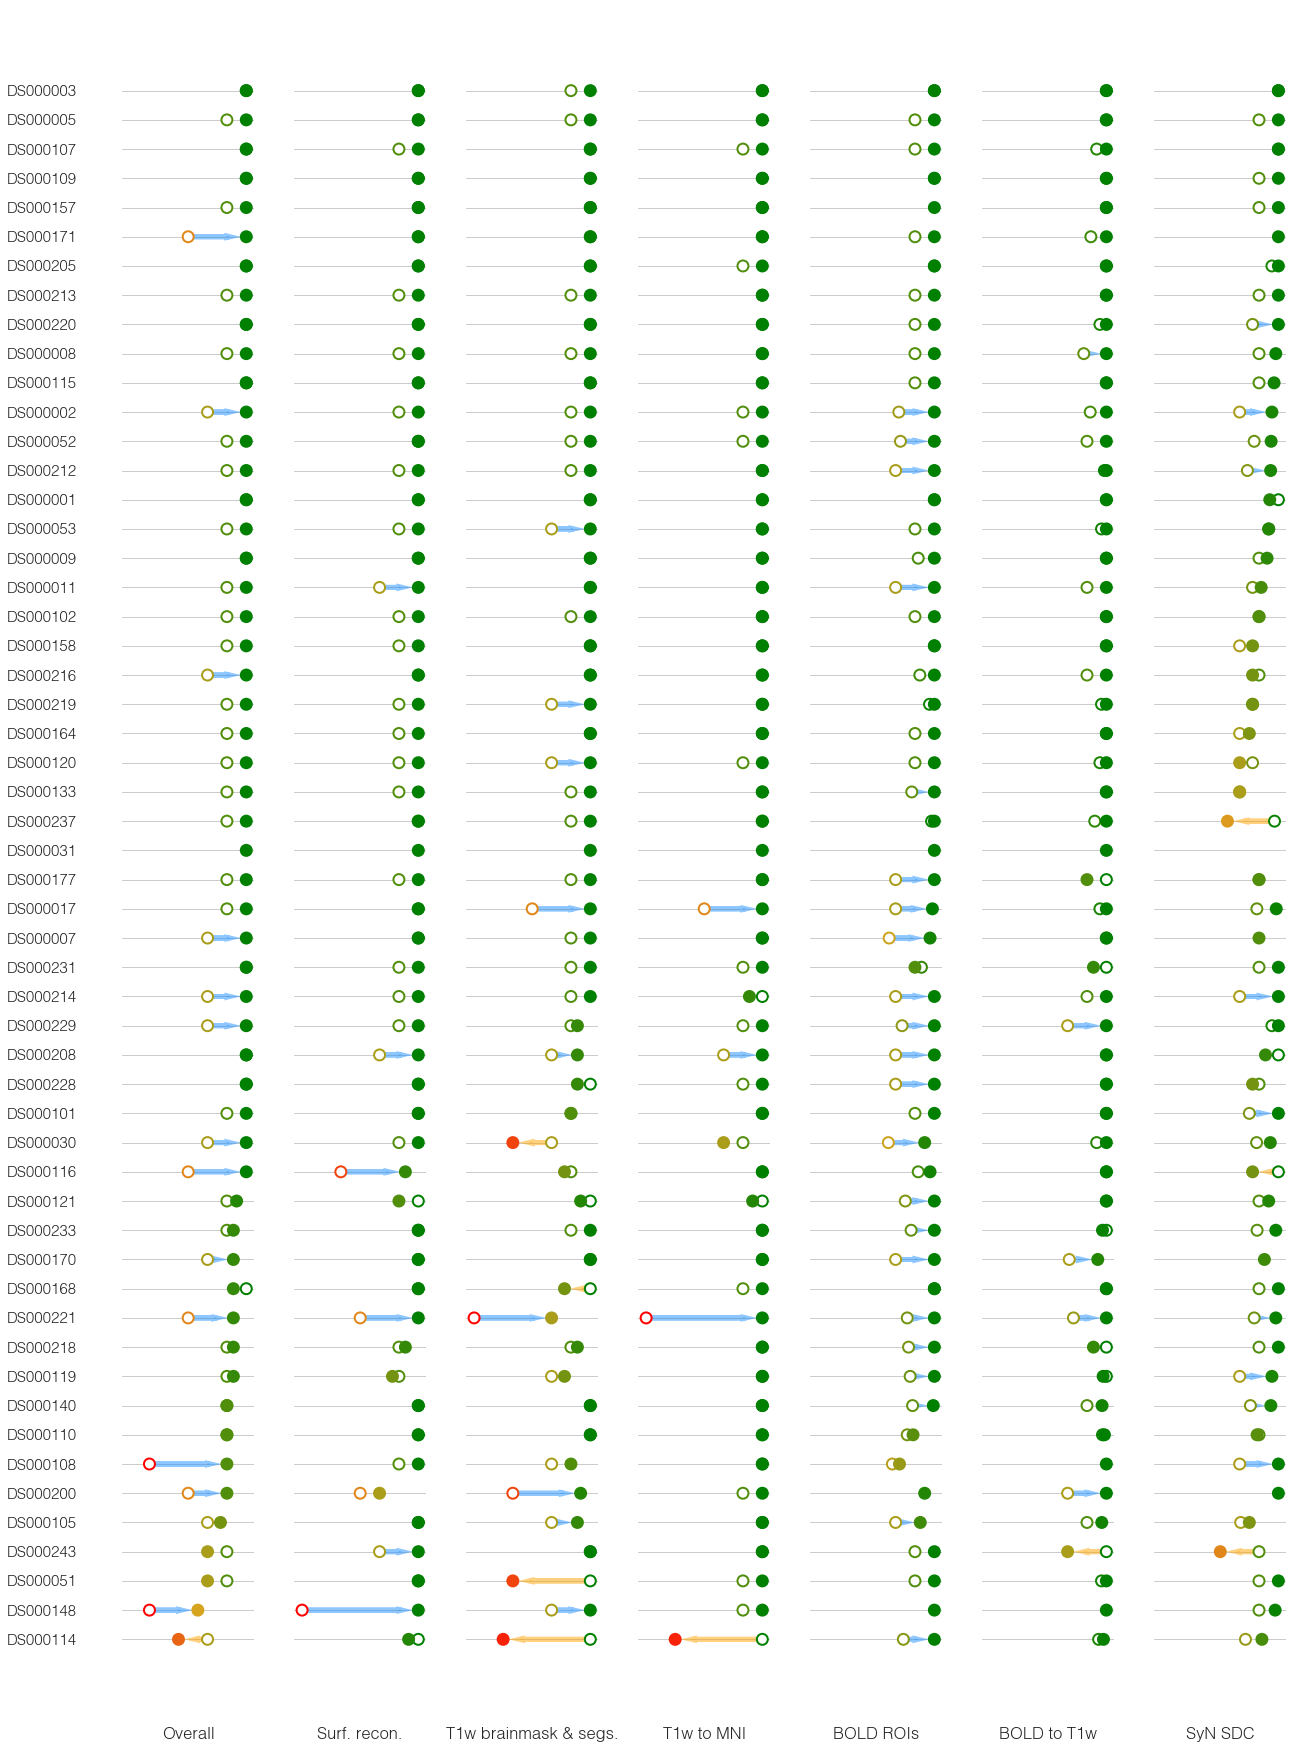

In [11]:
import seaborn as sns
sns.set(style="whitegrid", context='notebook', rc={
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Helvetica Light'],
})
sns.set_context("notebook", font_scale=1.5)

dataframe['dataset'] = dataframe.index.ravel()
dataframe0['dataset'] = dataframe0.index.ravel()

# Make the PairGrid
g = MyPairGrid(
    dataframe,
    dataframe0,
    x_vars=['overall', 't1_reconall', 't1_seg_brainmask', 't1_t1_2_mni',
            'bold_rois', 'bold_bbr', 'bold_syn_sdc'],
    y_vars=['dataset'],
    size=25, aspect=.10)

# Draw a dot plot using the stripplot function
g.map(mystripplot, size=15, orient="h")

# Use semantically meaningful titles for the columns
titles = ["Overall", "Surf. recon.", "T1w brainmask & segs.", 
          "T1w to MNI", "BOLD ROIs", "BOLD to T1w", "SyN SDC"]

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-0.2, 3.2), xlabel='', ylabel='')

datasets = dataframe.dataset.values.ravel()
g.axes.flat[0].set(yticks=range(len(datasets))[::-1])
g.axes.flat[0].set(yticklabels=datasets)
g.axes.flat[0].tick_params(axis='y', which='major', pad=45)
for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
#     ax.set(title=title)
    ax.set(xlabel=title)
    ax.set(xticks=[])
    
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
plt.savefig('figure04.pdf', format='pdf', bbox_inches='tight', pad_inches=0, dpi=300)